In [1]:
import boto3
import botocore
from io import StringIO
from iterdub import iterdub as ib
from iterpop import iterpop as ip
from matplotlib import pyplot as plt
import pandas as pd
from pandas.util import hash_pandas_object
import seaborn as sns
import statsmodels.api as sm
from teeplot import teeplot as tp

In [2]:
from dishpylib.pyhelpers import get_env_context
from dishpylib.pyhelpers import get_git_revision_hash
from dishpylib.pyhelpers import make_timestamp
from dishpylib.pyhelpers import print_runtime

In [3]:
print_runtime()

context: ci
hostname: 879fd5d404ff
interpreter: 3.8.15 (default, Oct 12 2022, 19:14:39)  [GCC 7.5.0]
revision: cde679bf0
timestamp: 2022-11-08T09:12:59Z00:00

IPython==7.16.1
boto3==1.14.44
botocore==1.17.44
iterdub==0.2.0
iterpop==0.3.4
matplotlib==3.5.2
pandas==1.1.2
seaborn==0.11.2
statsmodels==0.12.2
teeplot==0.1.1


# get data

In [4]:
s3_handle = boto3.resource(
    's3',
    region_name="us-east-2",
    config=botocore.config.Config(
        signature_version=botocore.UNSIGNED,
    ),
)
bucket_handle = s3_handle.Bucket('prq49')

series_profiles, = bucket_handle.objects.filter(
    Prefix=f'endeavor=16/series-profiles/stage=8+what=elaborated/',
)

In [5]:
df = pd.read_csv(
    f's3://prq49/{series_profiles.key}',
    compression='xz',
)
dfdigest = '{:x}'.format(hash_pandas_object( df ).sum())
dfdigest

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (2270,2277,2284,2285,2286,2287,2289,2290,2291,2292,2298,2299,2300,2301,2302,2308,2309,2310) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


'-4b8e8f9e4d8ca984'

# set up graphing utilities

In [6]:
def letterscatter(*,data,x,y,cat):
    sns.scatterplot(
        data=data,
        x=x,
        y=y,
        color='k',
        edgecolor='k',
        s=200,
    )
    sns.scatterplot(
        data=data,
        x=x,
        y=y,
        hue=cat,
        edgecolor=None,
        s=120,
    )
    sns.scatterplot(
        data=data,
        x=x,
        y=y,
        color='w',
        style=cat,
        markers={
            phen : f'$\mathrm{{{phen}}}$'
            for phen in data[cat].unique()
        },
        legend=False,
    )
    plt.legend(
        bbox_to_anchor=(1.01, 1),
        borderaxespad=0,
        title='Morph',
        frameon=False,
    )

In [7]:
def letterscatter_vline(*args, **kwargs):
    letterscatter(*args, **kwargs)
    plt.axvline(15,zorder=-2,c='k',ls=':')
    plt.axvline(45,zorder=-2,c='k',ls='--')

In [8]:
def letterscatter_vline_interpolationmissing(*args, **kwargs):
    letterscatter_vline(*args, **kwargs)

    for stint in dfx[ dfx['a=most_credible_idx+set_size=1'].isnull() ]['Stint']:
        plt.axvline(stint, c='gray', zorder=-2, alpha=0.5)



# preprocess data

In [9]:
morph_csv = StringIO('''Stint,Morph,Series
0,a,16005
1,b,16005
2,c,16005
3,b,16005
4,b,16005
5,b,16005
6,b,16005
7,b,16005
8,b,16005
9,b,16005
10,b,16005
11,b,16005
12,b,16005
13,b,16005
14,d,16005
15,e,16005
16,e,16005
17,e,16005
18,e,16005
19,e,16005
20,e,16005
21,e,16005
22,e,16005
23,e,16005
24,e,16005
25,e,16005
26,b,16005
27,e,16005
28,b,16005
29,e,16005
30,e,16005
31,e,16005
32,e,16005
33,e,16005
34,e,16005
35,e,16005
36,e,16005
37,e,16005
38,e,16005
39,f,16005
40,e,16005
41,e,16005
42,e,16005
43,e,16005
44,e,16005
45,g,16005
46,g,16005
47,g,16005
48,g,16005
49,g,16005
50,g,16005
51,g,16005
52,g,16005
53,e,16005
54,g,16005
55,g,16005
56,g,16005
57,g,16005
58,g,16005
59,h,16005
60,g,16005
61,e,16005
62,g,16005
63,g,16005
64,e,16005
65,e,16005
66,g,16005
67,g,16005
68,e,16005
69,g,16005
70,e,16005
71,e,16005
72,e,16005
73,g,16005
74,i,16005
75,i,16005
76,g,16005
77,i,16005
78,e,16005
79,g,16005
80,e,16005
81,e,16005
82,e,16005
83,e,16005
84,e,16005
85,e,16005
86,e,16005
87,e,16005
88,e,16005
89,g,16005
90,g,16005
91,e,16005
92,i,16005
93,e,16005
94,e,16005
95,b,16005
96,b,16005
97,h,16005
98,e,16005
99,e,16005
100,j,16005
''')

df_morph = pd.read_csv(morph_csv)

In [10]:
df = pd.merge(
    df,
    df_morph,
    on=['Stint', 'Series'],
    how='outer',
)

In [11]:
lowestroot_phylo_csv = StringIO('''proc,thread,Stint,Series,Lowest Num Stint Root IDs,Lowest Root ID
0,0,0,16005,1,2378
0,1,0,16005,1,2378
0,2,0,16005,1,2378
0,3,0,16005,1,2378
0,0,100,16005,25,12634
0,1,100,16005,26,12634
0,2,100,16005,24,12634
0,3,100,16005,22,12634
0,0,10,16005,4,12634
0,1,10,16005,3,12634
0,2,10,16005,4,12634
0,3,10,16005,3,12634
0,0,11,16005,3,12634
0,1,11,16005,3,12634
0,2,11,16005,2,12634
0,3,11,16005,3,12634
0,0,12,16005,4,12634
0,1,12,16005,4,12634
0,2,12,16005,4,12634
0,3,12,16005,4,12634
0,0,13,16005,2,12634
0,1,13,16005,2,12634
0,2,13,16005,2,12634
0,3,13,16005,2,12634
0,0,14,16005,3,12634
0,1,14,16005,3,12634
0,2,14,16005,3,12634
0,3,14,16005,3,12634
0,0,15,16005,3,12634
0,1,15,16005,4,12634
0,2,15,16005,4,12634
0,3,15,16005,4,12634
0,0,16,16005,4,12634
0,1,16,16005,3,12634
0,2,16,16005,3,12634
0,3,16,16005,2,12634
0,0,17,16005,9,12634
0,1,17,16005,5,12634
0,2,17,16005,5,12634
0,3,17,16005,3,12634
0,0,18,16005,7,12634
0,1,18,16005,7,12634
0,2,18,16005,3,12634
0,3,18,16005,6,12634
0,0,19,16005,8,12634
0,1,19,16005,11,12634
0,2,19,16005,6,12634
0,3,19,16005,7,12634
0,0,1,16005,1,2378
0,1,1,16005,1,2378
0,2,1,16005,1,2378
0,3,1,16005,2,2378
0,0,20,16005,8,12634
0,1,20,16005,9,12634
0,2,20,16005,9,12634
0,3,20,16005,11,12634
0,0,21,16005,10,12634
0,1,21,16005,9,12634
0,2,21,16005,11,12634
0,3,21,16005,6,12634
0,0,22,16005,11,12634
0,1,22,16005,10,12634
0,2,22,16005,8,12634
0,3,22,16005,10,12634
0,0,23,16005,7,12634
0,1,23,16005,10,12634
0,2,23,16005,15,12634
0,3,23,16005,13,12634
0,0,24,16005,10,12634
0,1,24,16005,5,12634
0,2,24,16005,13,12634
0,3,24,16005,7,12634
0,0,25,16005,13,12634
0,1,25,16005,15,12634
0,2,25,16005,5,12634
0,3,25,16005,9,12634
0,0,26,16005,6,12634
0,1,26,16005,6,12634
0,2,26,16005,7,12634
0,3,26,16005,8,12634
0,0,27,16005,11,12634
0,1,27,16005,9,12634
0,2,27,16005,9,12634
0,3,27,16005,6,12634
0,0,28,16005,8,12634
0,1,28,16005,6,12634
0,2,28,16005,13,12634
0,3,28,16005,9,12634
0,0,29,16005,7,12634
0,1,29,16005,8,12634
0,2,29,16005,9,12634
0,3,29,16005,10,12634
0,0,2,16005,2,12634
0,1,2,16005,3,12634
0,2,2,16005,2,12634
0,3,2,16005,2,12634
0,0,30,16005,10,12634
0,1,30,16005,10,12634
0,2,30,16005,16,12634
0,3,30,16005,11,12634
0,0,31,16005,11,12634
0,1,31,16005,12,12634
0,2,31,16005,9,12634
0,3,31,16005,12,12634
0,0,32,16005,10,12634
0,1,32,16005,9,12634
0,2,32,16005,14,12634
0,3,32,16005,15,12634
0,0,33,16005,12,12634
0,1,33,16005,18,12634
0,2,33,16005,13,12634
0,3,33,16005,19,12634
0,0,34,16005,23,12634
0,1,34,16005,25,12634
0,2,34,16005,17,12634
0,3,34,16005,22,12634
0,0,35,16005,13,12634
0,1,35,16005,15,12634
0,2,35,16005,14,12634
0,3,35,16005,13,12634
0,0,36,16005,13,12634
0,1,36,16005,17,12634
0,2,36,16005,16,12634
0,3,36,16005,23,12634
0,0,37,16005,8,12634
0,1,37,16005,12,12634
0,2,37,16005,9,12634
0,3,37,16005,17,12634
0,0,38,16005,16,12634
0,1,38,16005,16,12634
0,2,38,16005,18,12634
0,3,38,16005,15,12634
0,0,39,16005,19,12634
0,1,39,16005,21,12634
0,2,39,16005,10,12634
0,3,39,16005,14,12634
0,0,3,16005,6,12634
0,1,3,16005,6,12634
0,2,3,16005,4,12634
0,3,3,16005,7,12634
0,0,40,16005,16,12634
0,1,40,16005,15,12634
0,2,40,16005,17,12634
0,3,40,16005,17,12634
0,0,41,16005,18,12634
0,1,41,16005,19,12634
0,2,41,16005,26,12634
0,3,41,16005,20,12634
0,0,42,16005,18,12634
0,1,42,16005,17,12634
0,2,42,16005,16,12634
0,3,42,16005,12,12634
0,0,43,16005,22,12634
0,1,43,16005,26,12634
0,2,43,16005,18,12634
0,3,43,16005,18,12634
0,0,44,16005,20,12634
0,1,44,16005,14,12634
0,2,44,16005,17,12634
0,3,44,16005,13,12634
0,0,45,16005,8,12634
0,1,45,16005,17,12634
0,2,45,16005,14,12634
0,3,45,16005,18,12634
0,0,46,16005,14,12634
0,1,46,16005,16,12634
0,2,46,16005,14,12634
0,3,46,16005,16,12634
0,0,47,16005,11,12634
0,1,47,16005,11,12634
0,2,47,16005,16,12634
0,3,47,16005,25,12634
0,0,48,16005,12,12634
0,1,48,16005,17,12634
0,2,48,16005,15,12634
0,3,48,16005,15,12634
0,0,49,16005,13,12634
0,1,49,16005,11,12634
0,2,49,16005,13,12634
0,3,49,16005,15,12634
0,0,4,16005,5,12634
0,1,4,16005,4,12634
0,2,4,16005,3,12634
0,3,4,16005,5,12634
0,0,50,16005,15,12634
0,1,50,16005,13,12634
0,2,50,16005,12,12634
0,3,50,16005,11,12634
0,0,51,16005,13,12634
0,1,51,16005,14,12634
0,2,51,16005,9,12634
0,3,51,16005,11,12634
0,0,52,16005,24,12634
0,1,52,16005,14,12634
0,2,52,16005,15,12634
0,3,52,16005,21,12634
0,0,53,16005,17,12634
0,1,53,16005,13,12634
0,2,53,16005,16,12634
0,3,53,16005,21,12634
0,0,54,16005,12,12634
0,1,54,16005,12,12634
0,2,54,16005,13,12634
0,3,54,16005,14,12634
0,0,55,16005,14,12634
0,1,55,16005,11,12634
0,2,55,16005,12,12634
0,3,55,16005,17,12634
0,0,56,16005,12,12634
0,1,56,16005,19,12634
0,2,56,16005,13,12634
0,3,56,16005,15,12634
0,0,57,16005,24,12634
0,1,57,16005,23,12634
0,2,57,16005,20,12634
0,3,57,16005,19,12634
0,0,58,16005,17,12634
0,1,58,16005,17,12634
0,2,58,16005,17,12634
0,3,58,16005,16,12634
0,0,59,16005,18,12634
0,1,59,16005,13,12634
0,2,59,16005,13,12634
0,3,59,16005,12,12634
0,0,5,16005,5,12634
0,1,5,16005,6,12634
0,2,5,16005,6,12634
0,3,5,16005,6,12634
0,0,60,16005,20,12634
0,1,60,16005,19,12634
0,2,60,16005,18,12634
0,3,60,16005,20,12634
0,0,61,16005,14,12634
0,1,61,16005,16,12634
0,2,61,16005,9,12634
0,3,61,16005,14,12634
0,0,62,16005,12,12634
0,1,62,16005,11,12634
0,2,62,16005,10,12634
0,3,62,16005,15,12634
0,0,63,16005,12,12634
0,1,63,16005,13,12634
0,2,63,16005,13,12634
0,3,63,16005,15,12634
0,0,64,16005,14,12634
0,1,64,16005,13,12634
0,2,64,16005,11,12634
0,3,64,16005,10,12634
0,0,65,16005,12,12634
0,1,65,16005,15,12634
0,2,65,16005,13,12634
0,3,65,16005,13,12634
0,0,66,16005,16,12634
0,1,66,16005,15,12634
0,2,66,16005,17,12634
0,3,66,16005,13,12634
0,0,67,16005,10,12634
0,1,67,16005,8,12634
0,2,67,16005,6,12634
0,3,67,16005,11,12634
0,0,68,16005,8,12634
0,1,68,16005,10,12634
0,2,68,16005,12,12634
0,3,68,16005,10,12634
0,0,69,16005,9,12634
0,1,69,16005,11,12634
0,2,69,16005,9,12634
0,3,69,16005,9,12634
0,0,6,16005,4,12634
0,1,6,16005,3,12634
0,2,6,16005,4,12634
0,3,6,16005,4,12634
0,0,70,16005,13,12634
0,1,70,16005,16,12634
0,2,70,16005,13,12634
0,3,70,16005,16,12634
0,0,71,16005,17,12634
0,1,71,16005,18,12634
0,2,71,16005,18,12634
0,3,71,16005,18,12634
0,0,72,16005,16,12634
0,1,72,16005,15,12634
0,2,72,16005,16,12634
0,3,72,16005,18,12634
0,0,73,16005,17,12634
0,1,73,16005,19,12634
0,2,73,16005,15,12634
0,3,73,16005,21,12634
0,0,74,16005,17,12634
0,1,74,16005,21,12634
0,2,74,16005,17,12634
0,3,74,16005,22,12634
0,0,75,16005,13,12634
0,1,75,16005,12,12634
0,2,75,16005,15,12634
0,3,75,16005,14,12634
0,0,76,16005,14,12634
0,1,76,16005,15,12634
0,2,76,16005,16,12634
0,3,76,16005,20,12634
0,0,77,16005,9,12634
0,1,77,16005,9,12634
0,2,77,16005,13,12634
0,3,77,16005,12,12634
0,0,78,16005,14,12634
0,1,78,16005,12,12634
0,2,78,16005,13,12634
0,3,78,16005,12,12634
0,0,79,16005,16,12634
0,1,79,16005,21,12634
0,2,79,16005,22,12634
0,3,79,16005,21,12634
0,0,7,16005,4,12634
0,1,7,16005,4,12634
0,2,7,16005,5,12634
0,3,7,16005,5,12634
0,0,80,16005,14,12634
0,1,80,16005,12,12634
0,2,80,16005,11,12634
0,3,80,16005,12,12634
0,0,81,16005,13,12634
0,1,81,16005,17,12634
0,2,81,16005,21,12634
0,3,81,16005,17,12634
0,0,82,16005,16,12634
0,1,82,16005,17,12634
0,2,82,16005,18,12634
0,3,82,16005,13,12634
0,0,83,16005,12,12634
0,1,83,16005,16,12634
0,2,83,16005,12,12634
0,3,83,16005,11,12634
0,0,84,16005,19,12634
0,1,84,16005,17,12634
0,2,84,16005,12,12634
0,3,84,16005,14,12634
0,0,85,16005,11,12634
0,1,85,16005,17,12634
0,2,85,16005,18,12634
0,3,85,16005,19,12634
0,0,86,16005,16,12634
0,1,86,16005,22,12634
0,2,86,16005,14,12634
0,3,86,16005,18,12634
0,0,87,16005,17,12634
0,1,87,16005,16,12634
0,2,87,16005,15,12634
0,3,87,16005,15,12634
0,0,88,16005,14,12634
0,1,88,16005,12,12634
0,2,88,16005,15,12634
0,3,88,16005,10,12634
0,0,89,16005,15,12634
0,1,89,16005,14,12634
0,2,89,16005,14,12634
0,3,89,16005,16,12634
0,0,8,16005,3,12634
0,1,8,16005,3,12634
0,2,8,16005,4,12634
0,3,8,16005,4,12634
0,0,90,16005,19,12634
0,1,90,16005,17,12634
0,2,90,16005,11,12634
0,3,90,16005,8,12634
0,0,91,16005,16,12634
0,1,91,16005,17,12634
0,2,91,16005,15,12634
0,3,91,16005,18,12634
0,0,92,16005,10,12634
0,1,92,16005,12,12634
0,2,92,16005,17,12634
0,3,92,16005,19,12634
0,0,93,16005,7,12634
0,1,93,16005,5,12634
0,2,93,16005,11,12634
0,3,93,16005,4,12634
0,0,94,16005,17,12634
0,1,94,16005,12,12634
0,2,94,16005,20,12634
0,3,94,16005,18,12634
0,0,95,16005,12,12634
0,1,95,16005,12,12634
0,2,95,16005,16,12634
0,3,95,16005,19,12634
0,0,96,16005,14,12634
0,1,96,16005,17,12634
0,2,96,16005,16,12634
0,3,96,16005,11,12634
0,0,97,16005,10,12634
0,1,97,16005,10,12634
0,2,97,16005,15,12634
0,3,97,16005,11,12634
0,0,98,16005,17,12634
0,1,98,16005,17,12634
0,2,98,16005,21,12634
0,3,98,16005,16,12634
0,0,99,16005,19,12634
0,1,99,16005,15,12634
0,2,99,16005,21,12634
0,3,99,16005,15,12634
0,0,9,16005,6,12634
0,1,9,16005,5,12634
0,2,9,16005,3,12634
0,3,9,16005,5,12634
''')

df_lowestroot_phylo = pd.read_csv(lowestroot_phylo_csv).groupby([
    'Series',
    'Stint',
]).mean().reset_index()

In [12]:
df = pd.merge(
    df,
    df_lowestroot_phylo,
    on=['Stint', 'Series'],
    how='outer',
)

In [13]:
dfm10 = df[ df['Stint'] % 10 == 0 ]

In [14]:
dfx = df[ df['Series'] == 16005 ].sort_values('Morph')

In [15]:
for stint in dfx['Stint'].unique():
    exec(f'dfx{stint} = dfx[ dfx["Stint"] == {stint} ]')

# how does fitness complexity change over time?

teeplots/bucket=prq49+cat=morph+endeavor=16+transform=filter-Series-16005+viz=letterscatter-vline+x=stint+y=critical-fitness-complexity+ext=.pdf
teeplots/bucket=prq49+cat=morph+endeavor=16+transform=filter-Series-16005+viz=letterscatter-vline+x=stint+y=critical-fitness-complexity+ext=.png


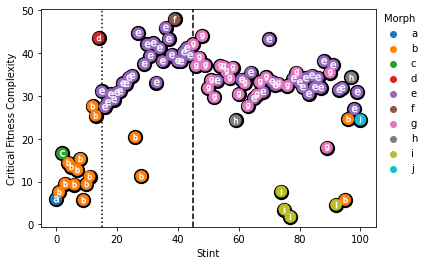

In [16]:
tp.tee(
    letterscatter_vline,
    data=dfx,
    x='Stint',
    y='Critical Fitness Complexity',
    cat='Morph',
    teeplot_outattrs={
        'bucket' : ib.dub( df['Bucket'] ),
        'endeavor' : ib.dub( df['Endeavor'].astype(int) ),
        'transform' : 'filter-Series-16005',
        '_context' : get_env_context(),
        '_dfdigest' : dfdigest,
        '_revision' : get_git_revision_hash(),
        '_timestamp' : make_timestamp(),
    },
)

teeplots/bucket=prq49+cat=morph+endeavor=16+transform=filter-Series-16005+viz=letterscatter-vline-interpolationmissing+x=stint+y=interpolated-fitness-complexity+ext=.pdf
teeplots/bucket=prq49+cat=morph+endeavor=16+transform=filter-Series-16005+viz=letterscatter-vline-interpolationmissing+x=stint+y=interpolated-fitness-complexity+ext=.png


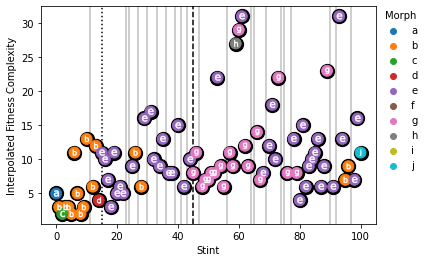

In [17]:
tp.tee(
    letterscatter_vline_interpolationmissing,
    data=dfx,
    x='Stint',
    y='Interpolated Fitness Complexity',
    cat='Morph',
    teeplot_outattrs={
        'bucket' : ib.dub( df['Bucket'] ),
        'endeavor' : ib.dub( df['Endeavor'].astype(int) ),
        'transform' : 'filter-Series-16005',
        '_context' : get_env_context(),
        '_dfdigest' : dfdigest,
        '_revision' : get_git_revision_hash(),
        '_timestamp' : make_timestamp(),
    },
)


teeplots/bucket=prq49+cat=morph+endeavor=16+transform=filter-Series-16005+viz=letterscatter-vline-interpolationmissing+x=stint+y=composite-fitness-complexity+ext=.pdf
teeplots/bucket=prq49+cat=morph+endeavor=16+transform=filter-Series-16005+viz=letterscatter-vline-interpolationmissing+x=stint+y=composite-fitness-complexity+ext=.png


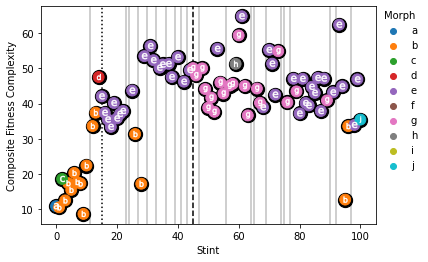

In [18]:
tp.tee(
    letterscatter_vline_interpolationmissing,
    data=dfx,
    x='Stint',
    y='Composite Fitness Complexity',
    cat='Morph',
    teeplot_outattrs={
        'bucket' : ib.dub( df['Bucket'] ),
        'endeavor' : ib.dub( df['Endeavor'].astype(int) ),
        'transform' : 'filter-Series-16005',
        '_context' : get_env_context(),
        '_dfdigest' : dfdigest,
        '_revision' : get_git_revision_hash(),
        '_timestamp' : make_timestamp(),
    },
)


teeplots/bucket=prq49+endeavor=16+transform=filter-Series-16005+viz=barplot+x=stint-decade+y=critical-fitness-complexity+ext=.pdf
teeplots/bucket=prq49+endeavor=16+transform=filter-Series-16005+viz=barplot+x=stint-decade+y=critical-fitness-complexity+ext=.png


<AxesSubplot:xlabel='Stint Decade', ylabel='Critical Fitness Complexity'>

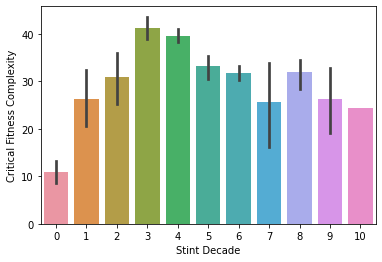

In [19]:
tp.tee(
    sns.barplot,
    data=dfx,
    x='Stint Decade',
    y='Critical Fitness Complexity',
    teeplot_outattrs={
        'bucket' : ib.dub( df['Bucket'] ),
        'endeavor' : ib.dub( df['Endeavor'].astype(int) ),
        'transform' : 'filter-Series-16005',
        '_context' : get_env_context(),
        '_dfdigest' : dfdigest,
        '_revision' : get_git_revision_hash(),
        '_timestamp' : make_timestamp(),
    },
)

teeplots/bucket=prq49+endeavor=16+transform=filter-Series-16005+viz=barplot+x=stint-decade+y=composite-fitness-complexity+ext=.pdf
teeplots/bucket=prq49+endeavor=16+transform=filter-Series-16005+viz=barplot+x=stint-decade+y=composite-fitness-complexity+ext=.png


<AxesSubplot:xlabel='Stint Decade', ylabel='Composite Fitness Complexity'>

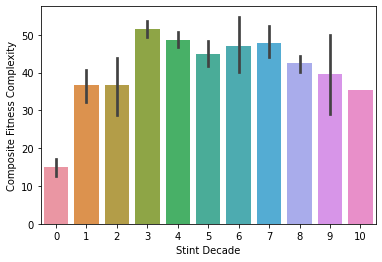

In [20]:
tp.tee(
    sns.barplot,
    data=dfx,
    x='Stint Decade',
    y='Composite Fitness Complexity',
    teeplot_outattrs={
        'bucket' : ib.dub( df['Bucket'] ),
        'endeavor' : ib.dub( df['Endeavor'].astype(int) ),
        'transform' : 'filter-Series-16005',
        '_context' : get_env_context(),
        '_dfdigest' : dfdigest,
        '_revision' : get_git_revision_hash(),
        '_timestamp' : make_timestamp(),
    },
)

teeplots/bucket=prq49+endeavor=16+transform=filter-Series-16005+viz=barplot+x=stint-decade+y=interpolated-fitness-complexity+ext=.pdf
teeplots/bucket=prq49+endeavor=16+transform=filter-Series-16005+viz=barplot+x=stint-decade+y=interpolated-fitness-complexity+ext=.png


<AxesSubplot:xlabel='Stint Decade', ylabel='Interpolated Fitness Complexity'>

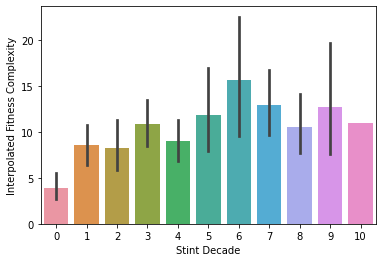

In [21]:
tp.tee(
    sns.barplot,
    data=dfx,
    x='Stint Decade',
    y='Interpolated Fitness Complexity',
    teeplot_outattrs={
        'bucket' : ib.dub( df['Bucket'] ),
        'endeavor' : ib.dub( df['Endeavor'].astype(int) ),
        'transform' : 'filter-Series-16005',
        '_context' : get_env_context(),
        '_dfdigest' : dfdigest,
        '_revision' : get_git_revision_hash(),
        '_timestamp' : make_timestamp(),
    },
)

# interpolation fitness complexity stuff

teeplots/bucket=prq49+endeavor=16+transform=filter-Series-16005+viz=regplot+x=interpolated-fitness-complexity+y=critical-fitness-complexity+ext=.pdf
teeplots/bucket=prq49+endeavor=16+transform=filter-Series-16005+viz=regplot+x=interpolated-fitness-complexity+y=critical-fitness-complexity+ext=.png


<class 'statsmodels.iolib.summary.Summary'>
"""
                                         OLS Regression Results                                        
=======================================================================================================
Dep. Variable:     Median Mutating Mutant Fitness Differential   R-squared:                       0.124
Model:                                                     OLS   Adj. R-squared:                  0.113
Method:                                          Least Squares   F-statistic:                     11.02
Date:                                         Tue, 08 Nov 2022   Prob (F-statistic):            0.00137
Time:                                                 09:13:18   Log-Likelihood:                 858.69
No. Observations:                                           80   AIC:                            -1713.
Df Residuals:                                               78   BIC:                            -1709.
Df Model:                                                    1                                         
Covariance Type:                                     nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                           -4.397e-06   1.14e-06     -3.857      0.000   -6.67e-06   -2.13e-06
Interpolated Fitness Complexity  -3.16e-07   9.52e-08     -3.319      0.001   -5.06e-07   -1.26e-07
==============================================================================
Omnibus:                       69.017   Durbin-Watson:                   1.626
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              649.426
Skew:                           2.434   Prob(JB):                    9.53e-142
Kurtosis:                      16.081   Cond. No.                         23.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

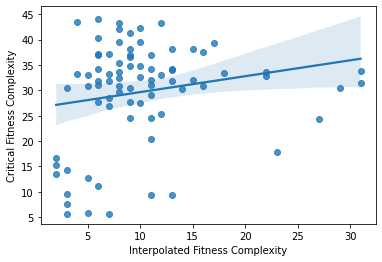

In [22]:
tp.tee(
    sns.regplot,
    data=dfx,
    x='Interpolated Fitness Complexity',
    y='Critical Fitness Complexity',
    teeplot_outattrs={
        'bucket' : ib.dub( df['Bucket'] ),
        'endeavor' : ib.dub( df['Endeavor'].astype(int) ),
        'transform' : 'filter-Series-16005',
        '_context' : get_env_context(),
        '_dfdigest' : dfdigest,
        '_revision' : get_git_revision_hash(),
        '_timestamp' : make_timestamp(),
    },
)

fil = dfx.dropna(subset=['Interpolated Fitness Complexity'])
sm.OLS(
    fil['Median Mutating Mutant Fitness Differential'],
    sm.add_constant(fil['Interpolated Fitness Complexity']),
).fit().summary()

teeplots/bucket=prq49+cat=morph+endeavor=16+transform=filter-Series-16005+viz=letterscatter-err-vline+x=stint+y=interpolated-fitness-complexity+ext=.pdf
teeplots/bucket=prq49+cat=morph+endeavor=16+transform=filter-Series-16005+viz=letterscatter-err-vline+x=stint+y=interpolated-fitness-complexity+ext=.png


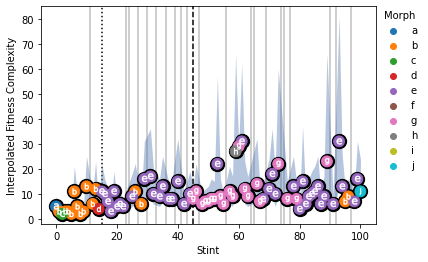

In [23]:
def letterscatter_err_vline(*args, **kwargs):

    x = kwargs['x']
    y = kwargs['y']

    data = kwargs['data'].dropna(subset=[y]).sort_values(x)
    plt.gca().fill_between(
        data[x],
        data['a=credible_interval_lower_bound_idx+set_size=1'],
        data['a=credible_interval_upper_bound_idx+set_size=1'],
        alpha=0.4,
        edgecolor='#4C72B0',
        facecolor='#4C72B0',
        linewidth=0,
    )

    letterscatter_vline_interpolationmissing(*args, **kwargs)

tp.tee(
    letterscatter_err_vline,
    data=dfx,
    x='Stint',
    y='Interpolated Fitness Complexity',
    cat='Morph',
    teeplot_outattrs={
        'bucket' : ib.dub( df['Bucket'] ),
        'endeavor' : ib.dub( df['Endeavor'].astype(int) ),
        'transform' : 'filter-Series-16005',
        '_context' : get_env_context(),
        '_dfdigest' : dfdigest,
        '_revision' : get_git_revision_hash(),
        '_timestamp' : make_timestamp(),
    },
)

teeplots/bucket=prq49+endeavor=16+transform=filter-Series-16005+viz=scatter-err-vline+x=stint+y=interpolated-fitness-complexity+ext=.pdf
teeplots/bucket=prq49+endeavor=16+transform=filter-Series-16005+viz=scatter-err-vline+x=stint+y=interpolated-fitness-complexity+ext=.png


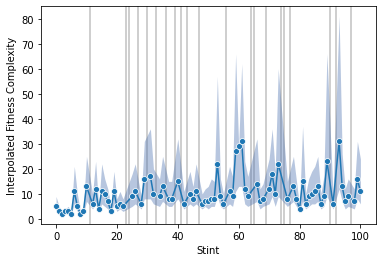

In [24]:
def scatter_err_vline(*args, **kwargs):

    x = kwargs['x']
    y = kwargs['y']

    kwargs['data'] = kwargs['data'].dropna(subset=[y]).sort_values(x)
    data = kwargs['data']


    plt.gca().fill_between(
        data[x],
        data['a=credible_interval_lower_bound_idx+set_size=1'],
        data['a=credible_interval_upper_bound_idx+set_size=1'],
        alpha=0.4,
        edgecolor='#4C72B0',
        facecolor='#4C72B0',
        linewidth=0,
    )
    sns.lineplot(
        *args,
        **kwargs,
        marker='o',
    )
    for stint in dfx[ dfx[y].isnull() ]['Stint']:
        plt.axvline(stint, c='gray', zorder=-2, alpha=0.5)


tp.tee(
    scatter_err_vline,
    data=dfx,
    x='Stint',
    y='Interpolated Fitness Complexity',
    teeplot_outattrs={
        'bucket' : ib.dub( df['Bucket'] ),
        'endeavor' : ib.dub( df['Endeavor'].astype(int) ),
        'transform' : 'filter-Series-16005',
        '_context' : get_env_context(),
        '_dfdigest' : dfdigest,
        '_revision' : get_git_revision_hash(),
        '_timestamp' : make_timestamp(),
    },
)

teeplots/bucket=prq49+endeavor=16+transform=filter-Series-16005+viz=countplot+x=most-credible-set-size+ext=.pdf
teeplots/bucket=prq49+endeavor=16+transform=filter-Series-16005+viz=countplot+x=most-credible-set-size+ext=.png


<AxesSubplot:xlabel='most_credible_set_size', ylabel='count'>

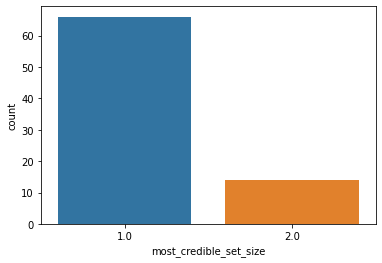

In [25]:
tp.tee(
    sns.countplot,
    data=dfx,
    x='most_credible_set_size',
    teeplot_outattrs={
        'bucket' : ib.dub( df['Bucket'] ),
        'endeavor' : ib.dub( df['Endeavor'].astype(int) ),
        'transform' : 'filter-Series-16005',
        '_context' : get_env_context(),
        '_dfdigest' : dfdigest,
        '_revision' : get_git_revision_hash(),
        '_timestamp' : make_timestamp(),
    },
)

teeplots/bucket=prq49+endeavor=16+hue=most-credible-set-size+transform=filter-Series-16005+viz=log-scatterplot+x=stint+y=a-most-credible-likelihood-set-size-1+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=most-credible-set-size+transform=filter-Series-16005+viz=log-scatterplot+x=stint+y=a-most-credible-likelihood-set-size-1+ext=.png


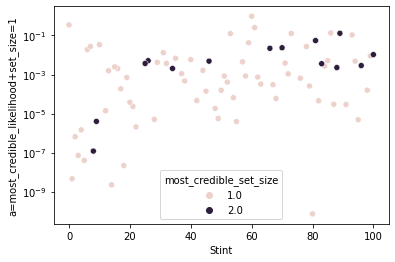

In [26]:
def log_scatterplot(*args, **kwargs):
    sns.scatterplot(
        *args,
        **kwargs,
    )
    plt.yscale('log')

tp.tee(
    log_scatterplot,
    data=dfx,
    x='Stint',
    y='a=most_credible_likelihood+set_size=1',
    hue='most_credible_set_size',
    teeplot_outattrs={
        'bucket' : ib.dub( df['Bucket'] ),
        'endeavor' : ib.dub( df['Endeavor'].astype(int) ),
        'transform' : 'filter-Series-16005',
        '_context' : get_env_context(),
        '_dfdigest' : dfdigest,
        '_revision' : get_git_revision_hash(),
        '_timestamp' : make_timestamp(),
    },
)

teeplots/bucket=prq49+endeavor=16+hue=none-nopped-is-less-fit+transform=filter-Series-16005+viz=scatterplot+x=stint+y=fitness-complexity+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=none-nopped-is-less-fit+transform=filter-Series-16005+viz=scatterplot+x=stint+y=fitness-complexity+ext=.png


<AxesSubplot:xlabel='Stint', ylabel='Fitness Complexity'>

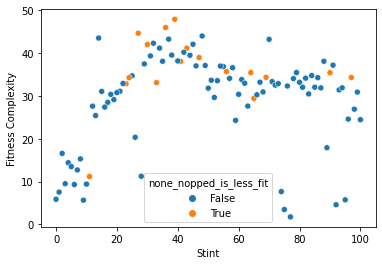

In [27]:
tp.tee(
    sns.scatterplot,
    data=dfx,
    x='Stint',
    y='Fitness Complexity',
    hue='none_nopped_is_less_fit',
    teeplot_outattrs={
        'bucket' : ib.dub( df['Bucket'] ),
        'endeavor' : ib.dub( df['Endeavor'].astype(int) ),
        'transform' : 'filter-Series-16005',
        '_context' : get_env_context(),
        '_dfdigest' : dfdigest,
        '_revision' : get_git_revision_hash(),
        '_timestamp' : make_timestamp(),
    },
)

# how does interface complexity change over time?

teeplots/bucket=prq49+cat=morph+endeavor=16+transform=filter-Series-16005+viz=letterscatter+x=stint+y=cardinal-interface-complexity+ext=.pdf
teeplots/bucket=prq49+cat=morph+endeavor=16+transform=filter-Series-16005+viz=letterscatter+x=stint+y=cardinal-interface-complexity+ext=.png


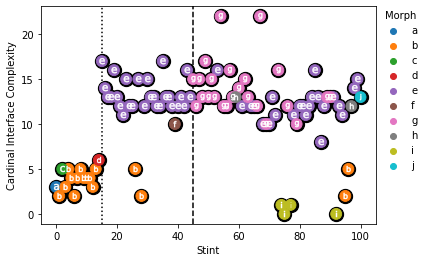

In [28]:
tp.tee(
    letterscatter_vline,
    data=dfx,
    x='Stint',
    y='Cardinal Interface Complexity',
    cat='Morph',
    teeplot_outattrs={
        'viz' : 'letterscatter', # override viz for backward naming compatibility
        'bucket' : ib.dub( df['Bucket'] ),
        'endeavor' : ib.dub( df['Endeavor'].astype(int) ),
        'transform' : 'filter-Series-16005',
        '_context' : get_env_context(),
        '_dfdigest' : dfdigest,
        '_revision' : get_git_revision_hash(),
        '_timestamp' : make_timestamp(),
    },
)

teeplots/bucket=prq49+endeavor=16+transform=filter-Series-16005+viz=barplot+x=stint-decade+y=cardinal-interface-complexity+ext=.pdf
teeplots/bucket=prq49+endeavor=16+transform=filter-Series-16005+viz=barplot+x=stint-decade+y=cardinal-interface-complexity+ext=.png


<AxesSubplot:xlabel='Stint Decade', ylabel='Cardinal Interface Complexity'>

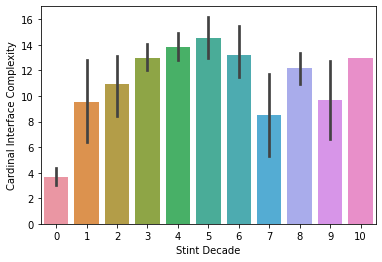

In [29]:
tp.tee(
    sns.barplot,
    data=dfx,
    x='Stint Decade',
    y='Cardinal Interface Complexity',
    teeplot_outattrs={
        'bucket' : ib.dub( df['Bucket'] ),
        'endeavor' : ib.dub( df['Endeavor'].astype(int) ),
        'transform' : 'filter-Series-16005',
        '_context' : get_env_context(),
        '_dfdigest' : dfdigest,
        '_revision' : get_git_revision_hash(),
        '_timestamp' : make_timestamp(),
    },
)

teeplots/bucket=prq49+endeavor=16+transform=filter-Series-16005+viz=regplot+x=cardinal-interface-complexity+y=critical-fitness-complexity+ext=.pdf
teeplots/bucket=prq49+endeavor=16+transform=filter-Series-16005+viz=regplot+x=cardinal-interface-complexity+y=critical-fitness-complexity+ext=.png


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:     Critical Fitness Complexity   R-squared:                       0.591
Model:                                     OLS   Adj. R-squared:                  0.587
Method:                          Least Squares   F-statistic:                     143.2
Date:                         Tue, 08 Nov 2022   Prob (F-statistic):           6.11e-21
Time:                                 09:13:26   Log-Likelihood:                -340.37
No. Observations:                          101   AIC:                             684.7
Df Residuals:                               99   BIC:                             690.0
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                            10.0940      1.791      5.634      0.000       6.539      13.649
Cardinal Interface Complexity     1.8033      0.151     11.965      0.000       1.504       2.102
==============================================================================
Omnibus:                        3.560   Durbin-Watson:                   1.700
Prob(Omnibus):                  0.169   Jarque-Bera (JB):                2.891
Skew:                           0.351   Prob(JB):                        0.236
Kurtosis:                       3.440   Cond. No.                         30.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

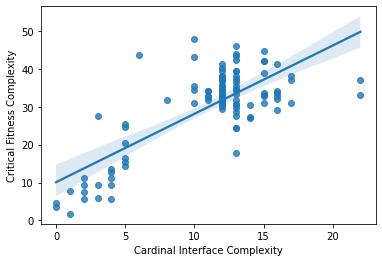

In [30]:
tp.tee(
    sns.regplot,
    data=dfx,
    x='Cardinal Interface Complexity',
    y='Critical Fitness Complexity',
    teeplot_outattrs={
        'bucket' : ib.dub( df['Bucket'] ),
        'endeavor' : ib.dub( df['Endeavor'].astype(int) ),
        'transform' : 'filter-Series-16005',
        '_context' : get_env_context(),
        '_dfdigest' : dfdigest,
        '_revision' : get_git_revision_hash(),
        '_timestamp' : make_timestamp(),
    },
)

sm.OLS(
    dfx['Critical Fitness Complexity'],
    sm.add_constant(dfx['Cardinal Interface Complexity']),
).fit().summary()

teeplots/bucket=prq49+cat=morph+endeavor=16+transform=filter-Series-16005+viz=letterscatter-vline+x=stint+y=num-less-fit-under-inter-self-send-filter-mod-20+ext=.pdf
teeplots/bucket=prq49+cat=morph+endeavor=16+transform=filter-Series-16005+viz=letterscatter-vline+x=stint+y=num-less-fit-under-inter-self-send-filter-mod-20+ext=.png


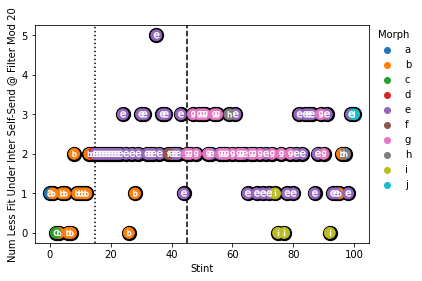

In [31]:
tp.tee(
    letterscatter_vline,
    data=dfx,
    x='Stint',
    y='Num Less Fit Under Inter Self-Send @ Filter Mod 20',
    cat='Morph',
    teeplot_outattrs={
        'bucket' : ib.dub( df['Bucket'] ),
        'endeavor' : ib.dub( df['Endeavor'].astype(int) ),
        'transform' : 'filter-Series-16005',
        '_context' : get_env_context(),
        '_dfdigest' : dfdigest,
        '_revision' : get_git_revision_hash(),
        '_timestamp' : make_timestamp(),
    },
)

teeplots/bucket=prq49+cat=morph+endeavor=16+transform=filter-Series-16005+viz=letterscatter-vline+x=stint+y=num-less-fit-under-intra-self-send-filter-mod-20+ext=.pdf
teeplots/bucket=prq49+cat=morph+endeavor=16+transform=filter-Series-16005+viz=letterscatter-vline+x=stint+y=num-less-fit-under-intra-self-send-filter-mod-20+ext=.png


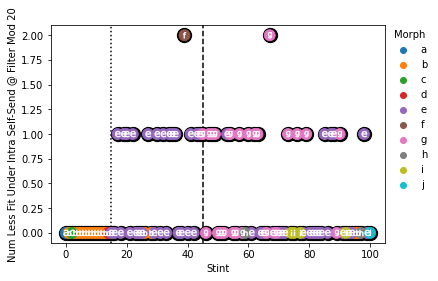

In [32]:
tp.tee(
    letterscatter_vline,
    data=dfx,
    x='Stint',
    y='Num Less Fit Under Intra Self-Send @ Filter Mod 20',
    cat='Morph',
    teeplot_outattrs={
        'bucket' : ib.dub( df['Bucket'] ),
        'endeavor' : ib.dub( df['Endeavor'].astype(int) ),
        'transform' : 'filter-Series-16005',
        '_context' : get_env_context(),
        '_dfdigest' : dfdigest,
        '_revision' : get_git_revision_hash(),
        '_timestamp' : make_timestamp(),
    },
)

teeplots/bucket=prq49+cat=morph+endeavor=16+transform=filter-Series-16005+viz=letterscatter-vline+x=stint+y=num-less-fit-under-extrospective-state-perturbation+ext=.pdf
teeplots/bucket=prq49+cat=morph+endeavor=16+transform=filter-Series-16005+viz=letterscatter-vline+x=stint+y=num-less-fit-under-extrospective-state-perturbation+ext=.png


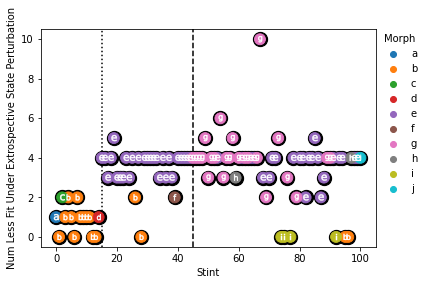

In [33]:
tp.tee(
    letterscatter_vline,
    data=dfx,
    x='Stint',
    y='Num Less Fit Under Extrospective State Perturbation',
    cat='Morph',
    teeplot_outattrs={
        'bucket' : ib.dub( df['Bucket'] ),
        'endeavor' : ib.dub( df['Endeavor'].astype(int) ),
        'transform' : 'filter-Series-16005',
        '_context' : get_env_context(),
        '_dfdigest' : dfdigest,
        '_revision' : get_git_revision_hash(),
        '_timestamp' : make_timestamp(),
    },
)

teeplots/bucket=prq49+cat=morph+endeavor=16+transform=filter-Series-16005+viz=letterscatter-vline+x=stint+y=num-less-fit-under-introspective-state-perturbation+ext=.pdf
teeplots/bucket=prq49+cat=morph+endeavor=16+transform=filter-Series-16005+viz=letterscatter-vline+x=stint+y=num-less-fit-under-introspective-state-perturbation+ext=.png


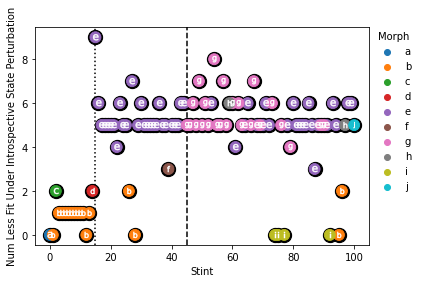

In [34]:
tp.tee(
    letterscatter_vline,
    data=dfx,
    x='Stint',
    y='Num Less Fit Under Introspective State Perturbation',
    cat='Morph',
    teeplot_outattrs={
        'bucket' : ib.dub( df['Bucket'] ),
        'endeavor' : ib.dub( df['Endeavor'].astype(int) ),
        'transform' : 'filter-Series-16005',
        '_context' : get_env_context(),
        '_dfdigest' : dfdigest,
        '_revision' : get_git_revision_hash(),
        '_timestamp' : make_timestamp(),
    },
)

teeplots/bucket=prq49+cat=morph+endeavor=16+transform=filter-Series-16005+viz=letterscatter-vline+x=stint+y=num-less-fit-under-writable-state-perturbation+ext=.pdf
teeplots/bucket=prq49+cat=morph+endeavor=16+transform=filter-Series-16005+viz=letterscatter-vline+x=stint+y=num-less-fit-under-writable-state-perturbation+ext=.png


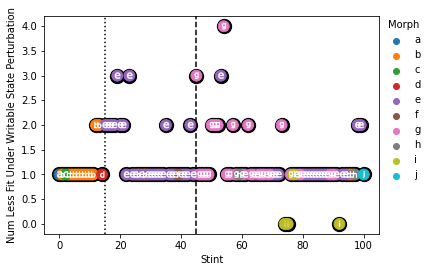

In [35]:
tp.tee(
    letterscatter_vline,
    data=dfx,
    x='Stint',
    y='Num Less Fit Under Writable State Perturbation',
    cat='Morph',
    teeplot_outattrs={
        'bucket' : ib.dub( df['Bucket'] ),
        'endeavor' : ib.dub( df['Endeavor'].astype(int) ),
        'transform' : 'filter-Series-16005',
        '_context' : get_env_context(),
        '_dfdigest' : dfdigest,
        '_revision' : get_git_revision_hash(),
        '_timestamp' : make_timestamp(),
    },
)

# how does phenotype complexity change over time?

teeplots/bucket=prq49+cat=morph+endeavor=16+transform=filter-Series-16005+viz=letterscatter-vline+x=stint+y=phenotype-complexity+ext=.pdf
teeplots/bucket=prq49+cat=morph+endeavor=16+transform=filter-Series-16005+viz=letterscatter-vline+x=stint+y=phenotype-complexity+ext=.png


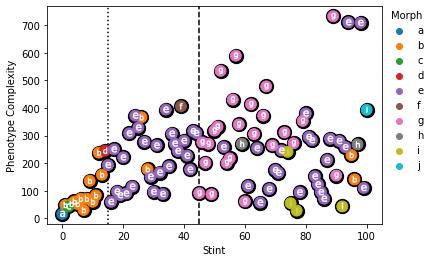

In [36]:
tp.tee(
    letterscatter_vline,
    data=dfx,
    x='Stint',
    y='Phenotype Complexity',
    cat='Morph',
    teeplot_outattrs={
        'bucket' : ib.dub( df['Bucket'] ),
        'endeavor' : ib.dub( df['Endeavor'].astype(int) ),
        'transform' : 'filter-Series-16005',
        '_context' : get_env_context(),
        '_dfdigest' : dfdigest,
        '_revision' : get_git_revision_hash(),
        '_timestamp' : make_timestamp(),
    },
)

# how does fitness change over time?

teeplots/bucket=prq49+cat=morph+endeavor=16+transform=filter-Series-16005+viz=letterscatter-vline-hline+x=stint+y=median-fitness-differential-against-immediate-predecessor-population+ext=.pdf
teeplots/bucket=prq49+cat=morph+endeavor=16+transform=filter-Series-16005+viz=letterscatter-vline-hline+x=stint+y=median-fitness-differential-against-immediate-predecessor-population+ext=.png


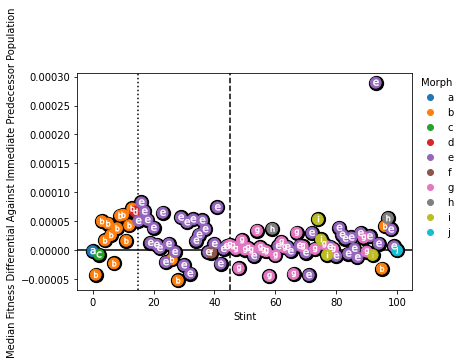

In [37]:
def letterscatter_vline_hline(*args, **kwargs):
    letterscatter_vline(*args, **kwargs)
    plt.axhline(c='k', zorder=-2)


tp.tee(
    letterscatter_vline_hline,
    data=dfx,
    x='Stint',
    y='Median Fitness Differential Against Immediate Predecessor Population',
    cat='Morph',
    teeplot_outattrs={
        'bucket' : ib.dub( df['Bucket'] ),
        'endeavor' : ib.dub( df['Endeavor'].astype(int) ),
        'transform' : 'filter-Series-16005',
        '_context' : get_env_context(),
        '_dfdigest' : dfdigest,
        '_revision' : get_git_revision_hash(),
        '_timestamp' : make_timestamp(),
    },
)

teeplots/bucket=prq49+cat=morph+endeavor=16+transform=filter-Series-16005+viz=letterscatter-vline-binomialh0+x=stint+y=fraction-immediate-predecessor-battles-won+ext=.pdf
teeplots/bucket=prq49+cat=morph+endeavor=16+transform=filter-Series-16005+viz=letterscatter-vline-binomialh0+x=stint+y=fraction-immediate-predecessor-battles-won+ext=.png


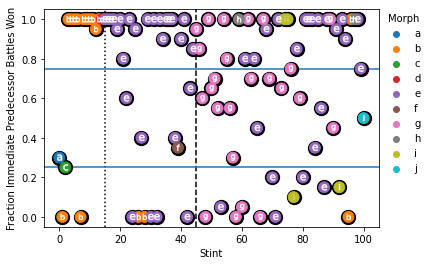

In [38]:
def letterscatter_vline_binomialh0(*args, **kwargs):

    letterscatter_vline(
        *args,
        **kwargs,
    )
    plt.axhline(
        0.25, # p ~= 0.01 for n = 20 binomial distribution
        zorder=-1,
    )
    plt.axhline(
        0.75, # p ~= 0.01 for n = 20 binomial distribution
        zorder=-1,
    )


tp.tee(
    letterscatter_vline_binomialh0,
    data=dfx,
    x='Stint',
    y='Fraction Immediate Predecessor Battles Won',
    cat='Morph',
    teeplot_outattrs={
        'bucket' : ib.dub( df['Bucket'] ),
        'endeavor' : ib.dub( df['Endeavor'].astype(int) ),
        'transform' : 'filter-Series-16005',
        '_context' : get_env_context(),
        '_dfdigest' : dfdigest,
        '_revision' : get_git_revision_hash(),
        '_timestamp' : make_timestamp(),
    },
)

teeplots/bucket=prq49+cat=morph+endeavor=16+transform=filter-Series-16005+viz=letterscatter-vline+x=stint+y=mean-doubling-time-growth-rate+ext=.pdf
teeplots/bucket=prq49+cat=morph+endeavor=16+transform=filter-Series-16005+viz=letterscatter-vline+x=stint+y=mean-doubling-time-growth-rate+ext=.png


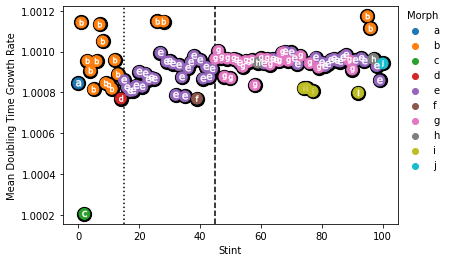

In [39]:
def letterscatter_vline(*args, **kwargs):
    letterscatter(*args, **kwargs)
    plt.axvline(15,zorder=-2,c='k',ls=':')
    plt.axvline(45,zorder=-2,c='k',ls='--')

tp.tee(
    letterscatter_vline,
    data=dfx,
    x='Stint',
    y='Mean Doubling Time Growth Rate',
    cat='Morph',
    teeplot_outattrs={
        'bucket' : ib.dub( df['Bucket'] ),
        'endeavor' : ib.dub( df['Endeavor'].astype(int) ),
        'transform' : 'filter-Series-16005',
        '_context' : get_env_context(),
        '_dfdigest' : dfdigest,
        '_revision' : get_git_revision_hash(),
        '_timestamp' : make_timestamp(),
    },
)

# how does robustness change over time?

teeplots/bucket=prq49+cat=morph+endeavor=16+transform=filter-Series-16005+viz=letterscatter-vline+x=stint+y=fraction-mutations-that-are-deleterious+ext=.pdf
teeplots/bucket=prq49+cat=morph+endeavor=16+transform=filter-Series-16005+viz=letterscatter-vline+x=stint+y=fraction-mutations-that-are-deleterious+ext=.png


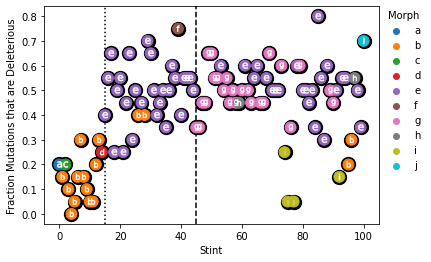

In [40]:
tp.tee(
    letterscatter_vline,
    data=dfx,
    x='Stint',
    y='Fraction Mutations that are Deleterious',
    cat='Morph',
    teeplot_outattrs={
        'bucket' : ib.dub( df['Bucket'] ),
        'endeavor' : ib.dub( df['Endeavor'].astype(int) ),
        'transform' : 'filter-Series-16005',
        '_context' : get_env_context(),
        '_dfdigest' : dfdigest,
        '_revision' : get_git_revision_hash(),
        '_timestamp' : make_timestamp(),
    },
)

teeplots/bucket=prq49+cat=morph+endeavor=16+transform=filter-Series-16005+viz=letterscatter-vline-hline+x=stint+y=median-mutating-mutant-fitness-differential+ext=.pdf
teeplots/bucket=prq49+cat=morph+endeavor=16+transform=filter-Series-16005+viz=letterscatter-vline-hline+x=stint+y=median-mutating-mutant-fitness-differential+ext=.png


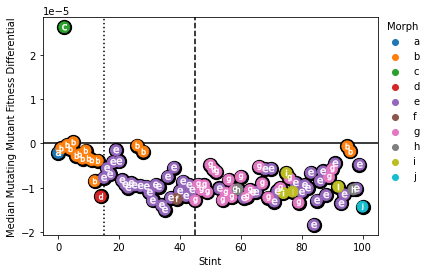

In [41]:
def letterscatter_vline_hline(*args, **kwargs):
    letterscatter_vline(*args, **kwargs)
    plt.axhline(c='k', zorder=-2)


tp.tee(
    letterscatter_vline_hline,
    data=dfx,
    x='Stint',
    y='Median Mutating Mutant Fitness Differential',
    cat='Morph',
    teeplot_outattrs={
        'bucket' : ib.dub( df['Bucket'] ),
        'endeavor' : ib.dub( df['Endeavor'].astype(int) ),
        'transform' : 'filter-Series-16005',
        '_context' : get_env_context(),
        '_dfdigest' : dfdigest,
        '_revision' : get_git_revision_hash(),
        '_timestamp' : make_timestamp(),
    },
)

teeplots/bucket=prq49+cat=morph+endeavor=16+transform=filter-Series-16005+viz=letterscatter+x=stint+y=fraction-mutating-mutations-that-are-deleterious+ext=.pdf
teeplots/bucket=prq49+cat=morph+endeavor=16+transform=filter-Series-16005+viz=letterscatter+x=stint+y=fraction-mutating-mutations-that-are-deleterious+ext=.png


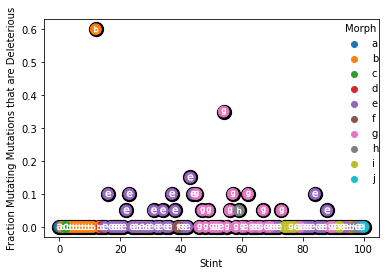

In [42]:
tp.tee(
    letterscatter,
    data=dfx,
    x='Stint',
    y='Fraction Mutating Mutations that are Deleterious',
    cat='Morph',
    teeplot_outattrs={
        'bucket' : ib.dub( df['Bucket'] ),
        'endeavor' : ib.dub( df['Endeavor'].astype(int) ),
        'transform' : 'filter-Series-16005',
        '_context' : get_env_context(),
        '_dfdigest' : dfdigest,
        '_revision' : get_git_revision_hash(),
        '_timestamp' : make_timestamp(),
    },
)

teeplots/bucket=prq49+endeavor=16+transform=filter-Series-16005+viz=regplot+x=critical-fitness-complexity+y=median-mutating-mutant-fitness-differential+ext=.pdf
teeplots/bucket=prq49+endeavor=16+transform=filter-Series-16005+viz=regplot+x=critical-fitness-complexity+y=median-mutating-mutant-fitness-differential+ext=.png


<class 'statsmodels.iolib.summary.Summary'>
"""
                                         OLS Regression Results                                        
=======================================================================================================
Dep. Variable:     Median Mutating Mutant Fitness Differential   R-squared:                       0.259
Model:                                                     OLS   Adj. R-squared:                  0.251
Method:                                          Least Squares   F-statistic:                     34.54
Date:                                         Tue, 08 Nov 2022   Prob (F-statistic):           5.65e-08
Time:                                                 09:13:45   Log-Likelihood:                 1101.5
No. Observations:                                          101   AIC:                            -2199.
Df Residuals:                                               99   BIC:                            -2194.
Df Model:                                                    1                                         
Covariance Type:                                     nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           -9e-07   1.29e-06     -0.699      0.486   -3.46e-06    1.66e-06
Critical Fitness Complexity -2.384e-07   4.06e-08     -5.877      0.000   -3.19e-07   -1.58e-07
==============================================================================
Omnibus:                      103.039   Durbin-Watson:                   1.484
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2132.613
Skew:                           3.091   Prob(JB):                         0.00
Kurtosis:                      24.646   Cond. No.                         91.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

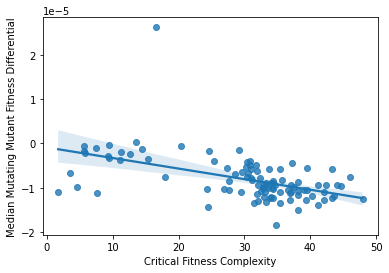

In [43]:
tp.tee(
    sns.regplot,
    data=dfx,
    x='Critical Fitness Complexity',
    y='Median Mutating Mutant Fitness Differential',
    teeplot_outattrs={
        'bucket' : ib.dub( df['Bucket'] ),
        'endeavor' : ib.dub( df['Endeavor'].astype(int) ),
        'transform' : 'filter-Series-16005',
        '_context' : get_env_context(),
        '_dfdigest' : dfdigest,
        '_revision' : get_git_revision_hash(),
        '_timestamp' : make_timestamp(),
    },
)
sm.OLS(
    dfx['Median Mutating Mutant Fitness Differential'],
    sm.add_constant(dfx['Critical Fitness Complexity']),
).fit().summary()

teeplots/bucket=prq49+endeavor=16+transform=filter-Series-16005+viz=regplot+x=interpolated-fitness-complexity+y=median-mutating-mutant-fitness-differential+ext=.pdf
teeplots/bucket=prq49+endeavor=16+transform=filter-Series-16005+viz=regplot+x=interpolated-fitness-complexity+y=median-mutating-mutant-fitness-differential+ext=.png


<class 'statsmodels.iolib.summary.Summary'>
"""
                                         OLS Regression Results                                        
=======================================================================================================
Dep. Variable:     Median Mutating Mutant Fitness Differential   R-squared:                       0.124
Model:                                                     OLS   Adj. R-squared:                  0.113
Method:                                          Least Squares   F-statistic:                     11.02
Date:                                         Tue, 08 Nov 2022   Prob (F-statistic):            0.00137
Time:                                                 09:13:46   Log-Likelihood:                 858.69
No. Observations:                                           80   AIC:                            -1713.
Df Residuals:                                               78   BIC:                            -1709.
Df Model:                                                    1                                         
Covariance Type:                                     nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                           -4.397e-06   1.14e-06     -3.857      0.000   -6.67e-06   -2.13e-06
Interpolated Fitness Complexity  -3.16e-07   9.52e-08     -3.319      0.001   -5.06e-07   -1.26e-07
==============================================================================
Omnibus:                       69.017   Durbin-Watson:                   1.626
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              649.426
Skew:                           2.434   Prob(JB):                    9.53e-142
Kurtosis:                      16.081   Cond. No.                         23.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

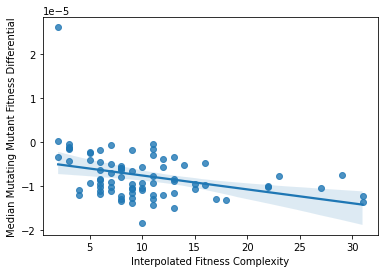

In [44]:
tp.tee(
    sns.regplot,
    data=dfx,
    x='Interpolated Fitness Complexity',
    y='Median Mutating Mutant Fitness Differential',
    teeplot_outattrs={
        'bucket' : ib.dub( df['Bucket'] ),
        'endeavor' : ib.dub( df['Endeavor'].astype(int) ),
        'transform' : 'filter-Series-16005',
        '_context' : get_env_context(),
        '_dfdigest' : dfdigest,
        '_revision' : get_git_revision_hash(),
        '_timestamp' : make_timestamp(),
    },
)

fil = dfx.dropna(subset=['Interpolated Fitness Complexity'])
sm.OLS(
    fil['Median Mutating Mutant Fitness Differential'],
    sm.add_constant(fil['Interpolated Fitness Complexity']),
).fit().summary()

teeplots/bucket=prq49+endeavor=16+transform=filter-Series-16005+viz=regplot+x=cardinal-interface-complexity+y=median-mutating-mutant-fitness-differential+ext=.pdf
teeplots/bucket=prq49+endeavor=16+transform=filter-Series-16005+viz=regplot+x=cardinal-interface-complexity+y=median-mutating-mutant-fitness-differential+ext=.png


<class 'statsmodels.iolib.summary.Summary'>
"""
                                         OLS Regression Results                                        
=======================================================================================================
Dep. Variable:     Median Mutating Mutant Fitness Differential   R-squared:                       0.214
Model:                                                     OLS   Adj. R-squared:                  0.206
Method:                                          Least Squares   F-statistic:                     26.94
Date:                                         Tue, 08 Nov 2022   Prob (F-statistic):           1.12e-06
Time:                                                 09:13:47   Log-Likelihood:                 1098.5
No. Observations:                                          101   AIC:                            -2193.
Df Residuals:                                               99   BIC:                            -2188.
Df Model:                                                    1                                         
Covariance Type:                                     nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                         -2.448e-06   1.16e-06     -2.102      0.038   -4.76e-06   -1.37e-07
Cardinal Interface Complexity -5.085e-07    9.8e-08     -5.190      0.000   -7.03e-07   -3.14e-07
==============================================================================
Omnibus:                       98.152   Durbin-Watson:                   1.699
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1717.935
Skew:                           2.942   Prob(JB):                         0.00
Kurtosis:                      22.328   Cond. No.                         30.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

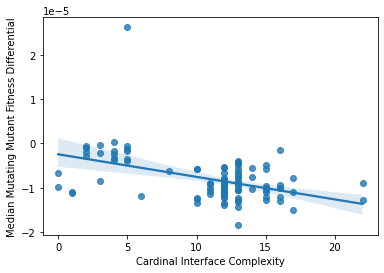

In [45]:
tp.tee(
    sns.regplot,
    data=dfx,
    x='Cardinal Interface Complexity',
    y='Median Mutating Mutant Fitness Differential',
    teeplot_outattrs={
        'bucket' : ib.dub( df['Bucket'] ),
        'endeavor' : ib.dub( df['Endeavor'].astype(int) ),
        'transform' : 'filter-Series-16005',
        '_context' : get_env_context(),
        '_dfdigest' : dfdigest,
        '_revision' : get_git_revision_hash(),
        '_timestamp' : make_timestamp(),
    },
)
sm.OLS(
    dfx['Median Mutating Mutant Fitness Differential'],
    sm.add_constant(dfx['Cardinal Interface Complexity']),
).fit().summary()

teeplots/bucket=prq49+endeavor=16+transform=filter-Series-16005+viz=log-boxplot+x=variable+y=median-fitness-differential+ext=.pdf
teeplots/bucket=prq49+endeavor=16+transform=filter-Series-16005+viz=log-boxplot+x=variable+y=median-fitness-differential+ext=.png


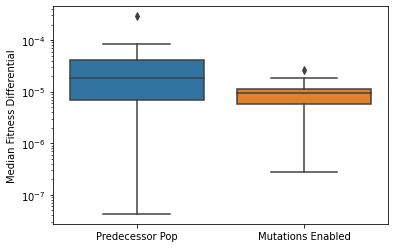

In [46]:
def log_boxplot(*args, **kwargs):
    sns.boxplot(*args, **kwargs)
    plt.yscale('log')
    plt.gca().set_xlabel(None)

tp.tee(
    log_boxplot,
    data=dfx.applymap(
        lambda x: abs(x) if type(x) in {float, int} else x
    ).rename(
        columns={
            'Median Fitness Differential Against Immediate Predecessor Population' : 'Predecessor Pop',
            'Median Mutating Mutant Fitness Differential' : 'Mutations Enabled',

        },
    ).melt(
        value_vars=[
            'Predecessor Pop',
            'Mutations Enabled',
        ],
        value_name='Median Fitness Differential',
    ),
    x='variable',
    y='Median Fitness Differential',
    teeplot_outattrs={
        'bucket' : ib.dub( df['Bucket'] ),
        'endeavor' : ib.dub( df['Endeavor'].astype(int) ),
        'transform' : 'filter-Series-16005',
        '_context' : get_env_context(),
        '_dfdigest' : dfdigest,
        '_revision' : get_git_revision_hash(),
        '_timestamp' : make_timestamp(),
    },
)

# how do phenotypic characteristics change over time?

teeplots/bucket=prq49+cat=morph+endeavor=16+transform=filter-Series-16005+viz=letterscatter+x=stint+y=mean-resource-received-per-cell-evolve-mean+ext=.pdf
teeplots/bucket=prq49+cat=morph+endeavor=16+transform=filter-Series-16005+viz=letterscatter+x=stint+y=mean-resource-received-per-cell-evolve-mean+ext=.png


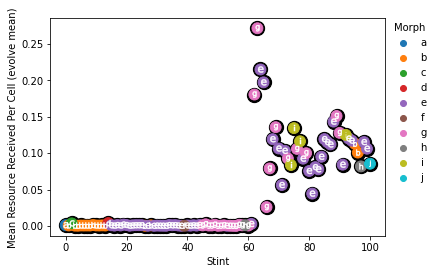

In [47]:
tp.tee(
    letterscatter,
    data=dfx,
    x='Stint',
    y='Mean Resource Received Per Cell (evolve mean)',
    cat='Morph',
    teeplot_outattrs={
        'bucket' : ib.dub( df['Bucket'] ),
        'endeavor' : ib.dub( df['Endeavor'].astype(int) ),
        'transform' : 'filter-Series-16005',
        '_context' : get_env_context(),
        '_dfdigest' : dfdigest,
        '_revision' : get_git_revision_hash(),
        '_timestamp' : make_timestamp(),
    },
)

teeplots/bucket=prq49+cat=morph+endeavor=16+transform=filter-Series-16005+viz=letterscatter+x=stint+y=resource-receiving-cell-fraction-evolve-mean+ext=.pdf
teeplots/bucket=prq49+cat=morph+endeavor=16+transform=filter-Series-16005+viz=letterscatter+x=stint+y=resource-receiving-cell-fraction-evolve-mean+ext=.png


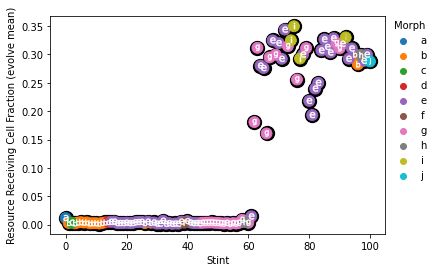

In [48]:
tp.tee(
    letterscatter,
    data=dfx,
    x='Stint',
    y='Resource Receiving Cell Fraction (evolve mean)',
    cat='Morph',
    teeplot_outattrs={
        'bucket' : ib.dub( df['Bucket'] ),
        'endeavor' : ib.dub( df['Endeavor'].astype(int) ),
        'transform' : 'filter-Series-16005',
        '_context' : get_env_context(),
        '_dfdigest' : dfdigest,
        '_revision' : get_git_revision_hash(),
        '_timestamp' : make_timestamp(),
    },
)

teeplots/bucket=prq49+cat=morph+endeavor=16+transform=filter-Series-16005+viz=letterscatter-vline+x=stint+y=mean-resource-received-per-cell-monoculture-mean+ext=.pdf
teeplots/bucket=prq49+cat=morph+endeavor=16+transform=filter-Series-16005+viz=letterscatter-vline+x=stint+y=mean-resource-received-per-cell-monoculture-mean+ext=.png


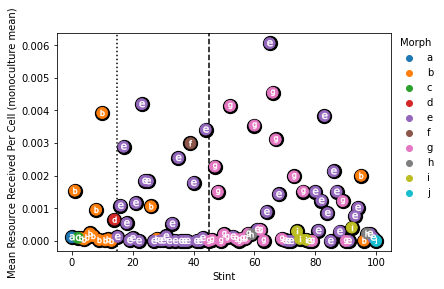

In [49]:
tp.tee(
    letterscatter_vline,
    data=dfx,
    x='Stint',
    y='Mean Resource Received Per Cell (monoculture mean)',
    cat='Morph',
    teeplot_outattrs={
        'bucket' : ib.dub( df['Bucket'] ),
        'endeavor' : ib.dub( df['Endeavor'].astype(int) ),
        'transform' : 'filter-Series-16005',
        '_context' : get_env_context(),
        '_dfdigest' : dfdigest,
        '_revision' : get_git_revision_hash(),
        '_timestamp' : make_timestamp(),
    },
)

teeplots/bucket=prq49+cat=morph+endeavor=16+transform=filter-Series-16005+viz=letterscatter-vline+x=stint+y=resource-receiving-cell-fraction-monoculture-mean+ext=.pdf
teeplots/bucket=prq49+cat=morph+endeavor=16+transform=filter-Series-16005+viz=letterscatter-vline+x=stint+y=resource-receiving-cell-fraction-monoculture-mean+ext=.png


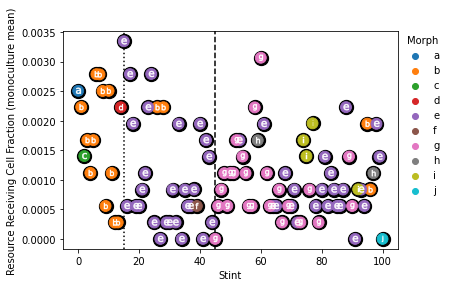

In [50]:
tp.tee(
    letterscatter_vline,
    data=dfx,
    x='Stint',
    y='Resource Receiving Cell Fraction (monoculture mean)',
    cat='Morph',
    teeplot_outattrs={
        'bucket' : ib.dub( df['Bucket'] ),
        'endeavor' : ib.dub( df['Endeavor'].astype(int) ),
        'transform' : 'filter-Series-16005',
        '_context' : get_env_context(),
        '_dfdigest' : dfdigest,
        '_revision' : get_git_revision_hash(),
        '_timestamp' : make_timestamp(),
    },
)

teeplots/bucket=prq49+cat=morph+endeavor=16+transform=filter-Series-16005+viz=log-letterscatter-vline-hline+x=stint+y=birth-conflict-ratio-for-kin-commonality-exactly-2+ext=.pdf
teeplots/bucket=prq49+cat=morph+endeavor=16+transform=filter-Series-16005+viz=log-letterscatter-vline-hline+x=stint+y=birth-conflict-ratio-for-kin-commonality-exactly-2+ext=.png


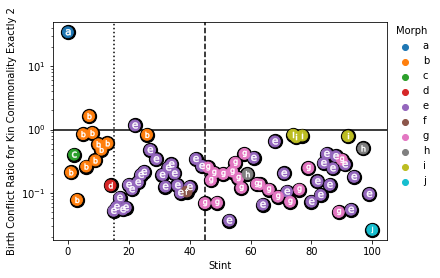

In [51]:
def log_letterscatter_vline_hline(*args, **kwargs):
    letterscatter_vline(*args, **kwargs)
    plt.yscale('log')
    plt.axhline(1, c='k', zorder=-1)

tp.tee(
    log_letterscatter_vline_hline,
    data=dfx,
    x='Stint',
    y='Birth Conflict Ratio for Kin Commonality Exactly 2',
    cat='Morph',
    teeplot_outattrs={
        'bucket' : ib.dub( df['Bucket'] ),
        'endeavor' : ib.dub( df['Endeavor'].astype(int) ),
        'transform' : 'filter-Series-16005',
        '_context' : get_env_context(),
        '_dfdigest' : dfdigest,
        '_revision' : get_git_revision_hash(),
        '_timestamp' : make_timestamp(),
    },
)

teeplots/bucket=prq49+cat=morph+endeavor=16+transform=filter-Series-16005+viz=log-letterscatter-vline-hline+x=stint+y=birth-conflict-ratio-for-kin-commonality-exactly-1+ext=.pdf
teeplots/bucket=prq49+cat=morph+endeavor=16+transform=filter-Series-16005+viz=log-letterscatter-vline-hline+x=stint+y=birth-conflict-ratio-for-kin-commonality-exactly-1+ext=.png


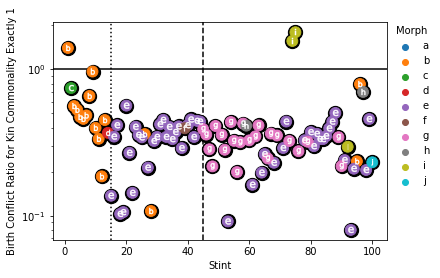

In [52]:
def log_letterscatter_vline_hline(*args, **kwargs):
    letterscatter_vline(*args, **kwargs)
    plt.yscale('log')
    plt.axhline(1, c='k', zorder=-1)


tp.tee(
    log_letterscatter_vline_hline,
    data=dfx,
    x='Stint',
    y='Birth Conflict Ratio for Kin Commonality Exactly 1',
    cat='Morph',
    teeplot_outattrs={
        'bucket' : ib.dub( df['Bucket'] ),
        'endeavor' : ib.dub( df['Endeavor'].astype(int) ),
        'transform' : 'filter-Series-16005',
        '_context' : get_env_context(),
        '_dfdigest' : dfdigest,
        '_revision' : get_git_revision_hash(),
        '_timestamp' : make_timestamp(),
    },
)

teeplots/bucket=prq49+cat=morph+endeavor=16+transform=filter-Series-16005+viz=log-letterscatter-vline-hline+x=stint+y=birth-conflict-ratio-for-kin-commonality-at-least-1+ext=.pdf
teeplots/bucket=prq49+cat=morph+endeavor=16+transform=filter-Series-16005+viz=log-letterscatter-vline-hline+x=stint+y=birth-conflict-ratio-for-kin-commonality-at-least-1+ext=.png


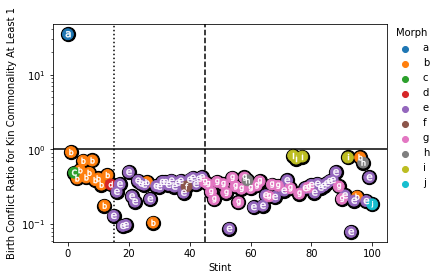

In [53]:
def log_letterscatter_vline_hline(*args, **kwargs):
    letterscatter_vline(*args, **kwargs)
    plt.yscale('log')
    plt.axhline(1, c='k', zorder=-1)


tp.tee(
    log_letterscatter_vline_hline,
    data=dfx,
    x='Stint',
    y='Birth Conflict Ratio for Kin Commonality At Least 1',
    cat='Morph',
    teeplot_outattrs={
        'bucket' : ib.dub( df['Bucket'] ),
        'endeavor' : ib.dub( df['Endeavor'].astype(int) ),
        'transform' : 'filter-Series-16005',
        '_context' : get_env_context(),
        '_dfdigest' : dfdigest,
        '_revision' : get_git_revision_hash(),
        '_timestamp' : make_timestamp(),
    },
)

teeplots/bucket=prq49+cat=morph+endeavor=16+transform=filter-Series-16005+viz=letterscatter-vline+x=stint+y=fraction-deaths-apoptosis-monoculture-mean+ext=.pdf
teeplots/bucket=prq49+cat=morph+endeavor=16+transform=filter-Series-16005+viz=letterscatter-vline+x=stint+y=fraction-deaths-apoptosis-monoculture-mean+ext=.png


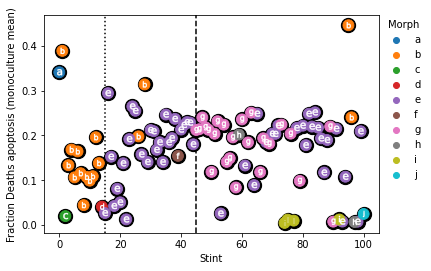

In [54]:
tp.tee(
    letterscatter_vline,
    data=dfx,
    x='Stint',
    y='Fraction Deaths apoptosis (monoculture mean)',
    cat='Morph',
    teeplot_outattrs={
        'bucket' : ib.dub( df['Bucket'] ),
        'endeavor' : ib.dub( df['Endeavor'].astype(int) ),
        'transform' : 'filter-Series-16005',
        '_context' : get_env_context(),
        '_dfdigest' : dfdigest,
        '_revision' : get_git_revision_hash(),
        '_timestamp' : make_timestamp(),
    },
)

# how does genetic structure change over time

teeplots/bucket=prq49+cat=morph+endeavor=16+transform=filter-Series-16005+viz=letterscatter-vline+x=stint+y=num-instructions+ext=.pdf
teeplots/bucket=prq49+cat=morph+endeavor=16+transform=filter-Series-16005+viz=letterscatter-vline+x=stint+y=num-instructions+ext=.png


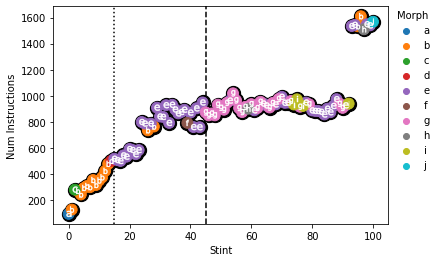

In [55]:
tp.tee(
    letterscatter_vline,
    data=dfx,
    x='Stint',
    y='Num Instructions',
    cat='Morph',
    teeplot_outattrs={
        'bucket' : ib.dub( df['Bucket'] ),
        'endeavor' : ib.dub( df['Endeavor'].astype(int) ),
        'transform' : 'filter-Series-16005',
        '_context' : get_env_context(),
        '_dfdigest' : dfdigest,
        '_revision' : get_git_revision_hash(),
        '_timestamp' : make_timestamp(),
    },
)

teeplots/bucket=prq49+cat=morph+endeavor=16+transform=filter-Series-16005+viz=letterscatter-vline+x=stint+y=mean-program-module-count-monoculture-mean+ext=.pdf
teeplots/bucket=prq49+cat=morph+endeavor=16+transform=filter-Series-16005+viz=letterscatter-vline+x=stint+y=mean-program-module-count-monoculture-mean+ext=.png


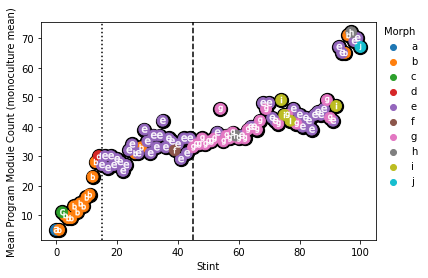

In [56]:
tp.tee(
    letterscatter_vline,
    data=dfx,
    x='Stint',
    y='Mean Program Module Count (monoculture mean)',
    cat='Morph',
    teeplot_outattrs={
        'bucket' : ib.dub( df['Bucket'] ),
        'endeavor' : ib.dub( df['Endeavor'].astype(int) ),
        'transform' : 'filter-Series-16005',
        '_context' : get_env_context(),
        '_dfdigest' : dfdigest,
        '_revision' : get_git_revision_hash(),
        '_timestamp' : make_timestamp(),
    },
)

# how does simulation efficiency change over time?

teeplots/bucket=prq49+cat=morph+endeavor=16+transform=filter-Series-16005+viz=letterscatter-vline+x=stint+y=update-evolve-mean+ext=.pdf
teeplots/bucket=prq49+cat=morph+endeavor=16+transform=filter-Series-16005+viz=letterscatter-vline+x=stint+y=update-evolve-mean+ext=.png


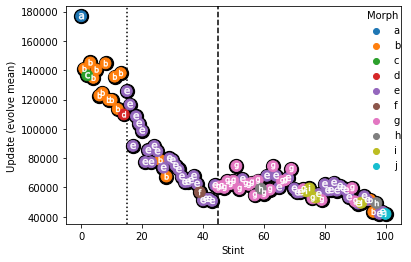

In [57]:
tp.tee(
    letterscatter_vline,
    data=dfx,
    x='Stint',
    y='Update (evolve mean)',
    cat='Morph',
    teeplot_outattrs={
        'bucket' : ib.dub( df['Bucket'] ),
        'endeavor' : ib.dub( df['Endeavor'].astype(int) ),
        'transform' : 'filter-Series-16005',
        '_context' : get_env_context(),
        '_dfdigest' : dfdigest,
        '_revision' : get_git_revision_hash(),
        '_timestamp' : make_timestamp(),
    },
)

teeplots/bucket=prq49+cat=morph+endeavor=16+transform=filter-Series-16005+viz=letterscatter-vline+x=stint+y=mean-instructions-executed-per-cardinal-update-monoculture-mean+ext=.pdf
teeplots/bucket=prq49+cat=morph+endeavor=16+transform=filter-Series-16005+viz=letterscatter-vline+x=stint+y=mean-instructions-executed-per-cardinal-update-monoculture-mean+ext=.png


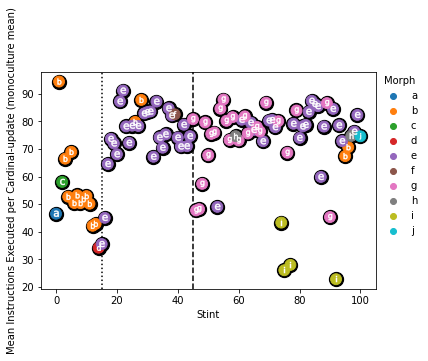

In [58]:
tp.tee(
    letterscatter_vline,
    data=dfx,
    x='Stint',
    y='Mean Instructions Executed per Cardinal-update (monoculture mean)',
    cat='Morph',
    teeplot_outattrs={
        'bucket' : ib.dub( df['Bucket'] ),
        'endeavor' : ib.dub( df['Endeavor'].astype(int) ),
        'transform' : 'filter-Series-16005',
        '_context' : get_env_context(),
        '_dfdigest' : dfdigest,
        '_revision' : get_git_revision_hash(),
        '_timestamp' : make_timestamp(),
    },
)

teeplots/bucket=prq49+cat=morph+endeavor=16+transform=filter-Series-16005+viz=letterscatter-vline+x=stint+y=update-monoculture-mean+ext=.pdf
teeplots/bucket=prq49+cat=morph+endeavor=16+transform=filter-Series-16005+viz=letterscatter-vline+x=stint+y=update-monoculture-mean+ext=.png


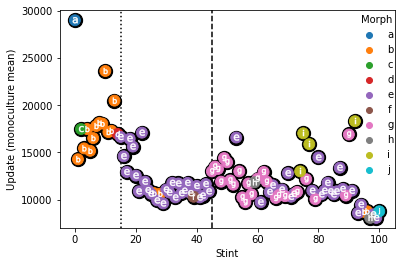

In [59]:
tp.tee(
    letterscatter_vline,
    data=dfx,
    x='Stint',
    y='Update (monoculture mean)',
    cat='Morph',
    teeplot_outattrs={
        'bucket' : ib.dub( df['Bucket'] ),
        'endeavor' : ib.dub( df['Endeavor'].astype(int) ),
        'transform' : 'filter-Series-16005',
        '_context' : get_env_context(),
        '_dfdigest' : dfdigest,
        '_revision' : get_git_revision_hash(),
        '_timestamp' : make_timestamp(),
    },
)

# how do phylogenetic metrics change over time?

teeplots/bucket=prq49+endeavor=16+transform=filter-Series-16005+viz=scatterplot+x=stint+y=selection-pressure+ext=.pdf
teeplots/bucket=prq49+endeavor=16+transform=filter-Series-16005+viz=scatterplot+x=stint+y=selection-pressure+ext=.png


<AxesSubplot:xlabel='Stint', ylabel='Selection Pressure'>

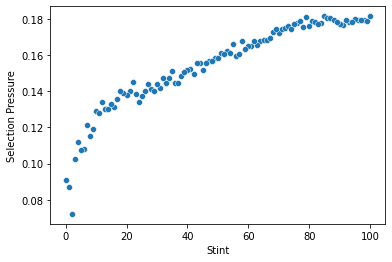

In [60]:
tp.tee(
    sns.scatterplot,
    data=dfx,
    x='Stint',
    y='Selection Pressure',
    teeplot_outattrs={
        'bucket' : ib.dub( df['Bucket'] ),
        'endeavor' : ib.dub( df['Endeavor'].astype(int) ),
        'transform' : 'filter-Series-16005',
        '_context' : get_env_context(),
        '_dfdigest' : dfdigest,
        '_revision' : get_git_revision_hash(),
        '_timestamp' : make_timestamp(),
    },
)

teeplots/bucket=prq49+cat=morph+endeavor=16+transform=filter-Series-16005+viz=letterscatter-vline+x=stint+y=number-stint-phylogenetic-roots-evolve-mean+ext=.pdf
teeplots/bucket=prq49+cat=morph+endeavor=16+transform=filter-Series-16005+viz=letterscatter-vline+x=stint+y=number-stint-phylogenetic-roots-evolve-mean+ext=.png


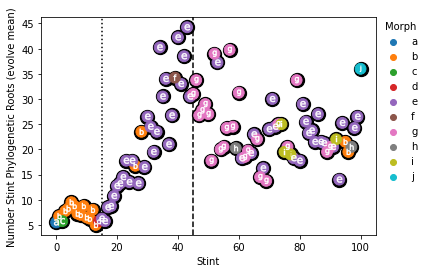

In [61]:
tp.tee(
    letterscatter_vline,
    data=dfx,
    x='Stint',
    y='Number Stint Phylogenetic Roots (evolve mean)',
    cat='Morph',
    teeplot_outattrs={
        'bucket' : ib.dub( df['Bucket'] ),
        'endeavor' : ib.dub( df['Endeavor'].astype(int) ),
        'transform' : 'filter-Series-16005',
        '_context' : get_env_context(),
        '_dfdigest' : dfdigest,
        '_revision' : get_git_revision_hash(),
        '_timestamp' : make_timestamp(),
    },
)

teeplots/bucket=prq49+cat=morph+endeavor=16+transform=filter-Series-16005+viz=letterscatter-vline+x=stint+y=lowest-num-stint-root-ids+ext=.pdf
teeplots/bucket=prq49+cat=morph+endeavor=16+transform=filter-Series-16005+viz=letterscatter-vline+x=stint+y=lowest-num-stint-root-ids+ext=.png


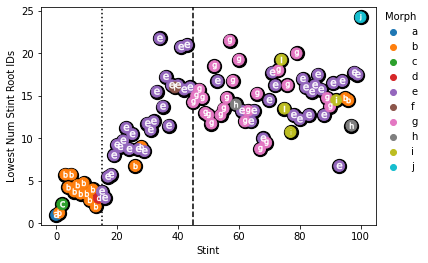

In [62]:
tp.tee(
    letterscatter_vline,
    data=dfx,
    x='Stint',
    y='Lowest Num Stint Root IDs',
    cat='Morph',
    teeplot_outattrs={
        'bucket' : ib.dub( df['Bucket'] ),
        'endeavor' : ib.dub( df['Endeavor'].astype(int) ),
        'transform' : 'filter-Series-16005',
        '_context' : get_env_context(),
        '_dfdigest' : dfdigest,
        '_revision' : get_git_revision_hash(),
        '_timestamp' : make_timestamp(),
    },
)

teeplots/bucket=prq49+cat=morph+endeavor=16+transform=filter-Series-16005+viz=letterscatter+x=stint+y=number-phylogenetic-roots-evolve-mean+ext=.pdf
teeplots/bucket=prq49+cat=morph+endeavor=16+transform=filter-Series-16005+viz=letterscatter+x=stint+y=number-phylogenetic-roots-evolve-mean+ext=.png


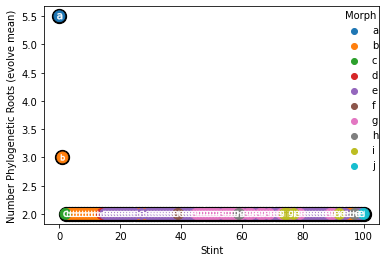

In [63]:
tp.tee(
    letterscatter,
    data=dfx,
    x='Stint',
    y='Number Phylogenetic Roots (evolve mean)',
    cat='Morph',
    teeplot_outattrs={
        'bucket' : ib.dub( df['Bucket'] ),
        'endeavor' : ib.dub( df['Endeavor'].astype(int) ),
        'transform' : 'filter-Series-16005',
        '_context' : get_env_context(),
        '_dfdigest' : dfdigest,
        '_revision' : get_git_revision_hash(),
        '_timestamp' : make_timestamp(),
    },
)

teeplots/bucket=prq49+cat=morph+endeavor=16+transform=filter-Series-16005+viz=log-letterscatter+x=number-stint-phylogenetic-roots-evolve-mean+y=update-evolve-mean+ext=.pdf
teeplots/bucket=prq49+cat=morph+endeavor=16+transform=filter-Series-16005+viz=log-letterscatter+x=number-stint-phylogenetic-roots-evolve-mean+y=update-evolve-mean+ext=.png


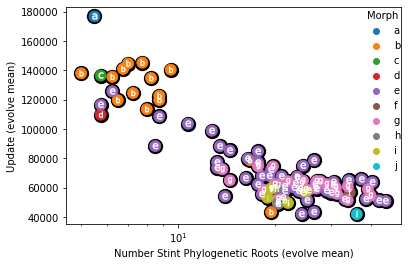

In [64]:
def log_letterscatter(*args, **kwargs):
    letterscatter(*args, **kwargs)
    plt.xscale('log')

tp.tee(
    log_letterscatter,
    data=dfx,
    x='Number Stint Phylogenetic Roots (evolve mean)',
    y='Update (evolve mean)',
    cat='Morph',
    teeplot_outattrs={
        'bucket' : ib.dub( df['Bucket'] ),
        'endeavor' : ib.dub( df['Endeavor'].astype(int) ),
        'transform' : 'filter-Series-16005',
        '_context' : get_env_context(),
        '_dfdigest' : dfdigest,
        '_revision' : get_git_revision_hash(),
        '_timestamp' : make_timestamp(),
    },
)


# phylogenetic info

In [65]:
for what in [
    'Elapsed Generations',
    'Elapsed Generations Level 0',
    'Elapsed Generations Level 1',
    'Elapsed Generations Level 2',
    'Elapsed Indel Mutations',
    'Elapsed Point Mutations',
    'Elapsed Mutations',
    'Selection Pressure',
    'Mean Elapsed Generations Level 0 (evolve mean)',
    'Mean Elapsed Generations Level 1 (evolve mean)',
    'Mean Elapsed Generations Level 2 (evolve mean)',
    'Mean Elapsed Indel Mutations (evolve mean)',
    'Mean Elapsed Point Mutations (evolve mean)',
    'Prevalent Genotype Quantity (evolve mean)',
    'Mean Current Epoch (evolve mean)',
]:

    print( what, ip.popsingleton(dfx[ dfx['Stint'] == df['Stint'].max() ][what]) )

Elapsed Generations 20212.0
Elapsed Generations Level 0 11713.0
Elapsed Generations Level 1 7174.0
Elapsed Generations Level 2 1325.0
Elapsed Indel Mutations 7240.0
Elapsed Point Mutations 26153.0
Elapsed Mutations 1672.0
Selection Pressure 0.18135526831179008
Mean Elapsed Generations Level 0 (evolve mean) 13203.575
Mean Elapsed Generations Level 1 (evolve mean) 9117.855
Mean Elapsed Generations Level 2 (evolve mean) 1575.6575
Mean Elapsed Indel Mutations (evolve mean) 12239.6
Mean Elapsed Point Mutations (evolve mean) 42658.325
Prevalent Genotype Quantity (evolve mean) 57.0
Mean Current Epoch (evolve mean) 5386.2875


In [66]:
print( 'total elapsed updates', dfx['Update (evolve mean)'].sum() )
print( 'mean elapsed updates', dfx['Update (evolve mean)'].mean() )
print( 'total elapsed epochs', dfx['Mean Current Epoch (evolve mean)'].sum() )
print( 'mean elapsed epochs', dfx['Mean Current Epoch (evolve mean)'].mean() )

total elapsed updates 7565309.0
mean elapsed updates 74904.0495049505
total elapsed epochs 981304.2250000001
mean elapsed epochs 9715.883415841585
